In [1]:
%load_ext blackcellmagic
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import yaml
from datetime import date
from scipy import ndimage

import matplotlib.pyplot as plt
import cv2 as cv
import ipywidgets as widget
from itertools import combinations
from itertools import product

from src.magfunctions import ImageProcessing
from src.magfunctions import PlotCoordinates

 # pyright: reportMissingModuleSource=false 

In [2]:
METADATA = {
    "author": "Magnus Wood",
}

# define camera wavelengths and file image labels in a dict
# RedEdge-MX Dual Camera Imaging System bands
# channel names: blue-444, blue, green-531, green, red-650, red, red-edge-705, red-edge, red-edge-740, nir
rededge_mx_band_wl = {
    "blue-444": 444,
    "blue": 475,
    "green-531": 531,
    "green": 560,
    "red-650": 650,
    "red": 668,
    "red-edge-705": 705,
    "red-edge": 717,
    "red-edge-740": 740,
    "nir": 842,
}

# define notebook parameters
params = {
    "project_stub": "Potato_Fertilizer_Othello",
    "image_format": "*.tif",
    "data_acquisition_date": "Jun22_2020",
    "NDVI_threshold": 0.3,
    "data_import_path": Path.cwd() / "data" / "raw" / "Jun22_2020",
    "data_export_path": Path.cwd() / "data" / "processed" / "Jun22_2020",
    "plot_export_path": Path.cwd() / "image_export" ,
    "ground_truth_path": Path.cwd() / "data" / "raw" / "ground_truth.csv",
}

improc = ImageProcessing(params = params)


# export the params file for reference
with open(
    Path.cwd()
    / "config"
    / (str(date.today()) + "_" + params["data_acquisition_date"] + "_" + "params.yaml"),
    "w",
) as file:
    documents = yaml.dump(params, file)

# Rotate and crop to field of interest
1. Load nir channel image
2. Rotate the image to line up crops with axes
3. crop to field of interest
4. plot for visual verification

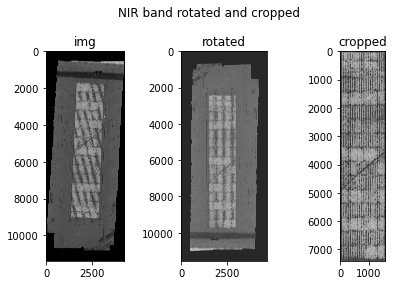

In [3]:
# 1.load nir channel as img array
img = improc.load_img("nir")

# 2. rotate
img_rotate = ndimage.rotate(img, angle=182.4, reshape=True)

# 3. crop
y_limits = [2400, 9800]
x_limits = [1460, 3050]
img_crop = img_rotate[y_limits[0] : y_limits[1], x_limits[0] : x_limits[1]]

# 4. plot as one figure
fig, axs = plt.subplots(1, 3)
fig.suptitle("NIR band rotated and cropped")
axs[0].imshow(img, cmap="gray")
axs[0].set_title("img")

axs[1].imshow(img_rotate, cmap="gray")
axs[1].set_title("rotated")

axs[2].imshow(img_crop, cmap="gray")
axs[2].set_title("cropped")

fig.tight_layout()

# Import full image stack
If the above images look good, we will next import all of the images into a numpy array stack. 

This code block uses list comprehension to create a list of rotated image arrays, and hands them to np.stack(), which returns an array with the shape of (channel, y, x). This can take a few minutes on some computers.



final field_image.shape: (10, 7400, 1590)


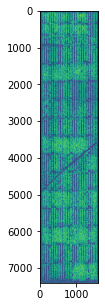

In [4]:
field_image = np.stack([ndimage.rotate(improc.load_img(channel_name), angle=182.4, reshape=True) for channel_name in rededge_mx_band_wl])

# origin is upper left
y_limits = [2400, 9800]
x_limits = [1460, 3050]

# crop to desired size (channels, y axis, x axis)
field_image = field_image[:, y_limits[0] : y_limits[1], x_limits[0] : x_limits[1]]
print(f"final field_image.shape: {field_image.shape}")

improc.show_image(field_image[9], size=(4,5))

# Test threshold values and create a mask
1. Calculate NDVI
2. Choose NDVI threshold
3. Create a boolean mask using the threshold
4. Apply the mask to the NDVI image.
5. Display masked NDVI image for verification

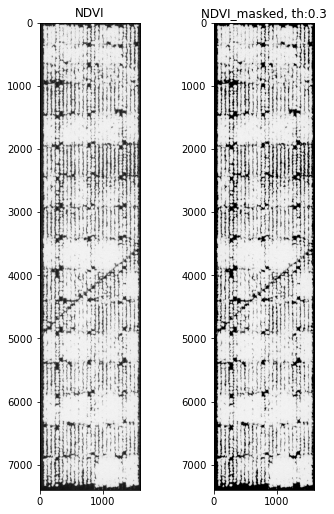

In [5]:
# 1. calculate NDVI
ndvi = improc.calc_spec_idx((9, 5), field_image)

# 2. choose ndvi threshold
ndvi_th = 0.3

# 3. create a boolean mask of pixels > ndvi_th
mask = np.where(ndvi > ndvi_th, True, False)

# 4. apply mask to cropped image
ndvi_masked = np.multiply(ndvi, mask)

# 5. Display the images as one figure.
fig, axs = plt.subplots(1, 2)
axs[0].imshow(ndvi, cmap="gray")

axs[0].set_title("NDVI")

axs[1].imshow(ndvi_masked, cmap="gray")
axs[1].set_title(f"NDVI_masked, th:{ndvi_th}")

fig.tight_layout()
fig.set_figheight(8)

# Congratulations! You have a field_image with all ten bands, and a mask to segment the background out from the vegetation.

In [6]:
# save the field_image array to disk for use in other notebooks
# this will be an np.array object, which can then be loaded using np.load()
array_filename = os.path.join(params["data_export_path"],f"{params['project_stub']}_{params['data_acquisition_date']}_fieldimage")
mask_filename = os.path.join(params["data_export_path"],f"{params['project_stub']}_{params['data_acquisition_date']}_mask")
np.save(file=array_filename, arr=field_image)
np.save(file=mask_filename, arr=mask)


# Define the NDSIs 
NDSIs are defined by the equation $\frac{a-b}{a+b}$, where a and b are different color bands taken from the available channels in the field image. There are 10 channels available on data taken from the camera utilized for this dataset, which would yield $\frac {10!}{(10-2)!}=90$ combinations. However, half of those would be the inverse of the other half: $\frac{a-b}{a+b}$ vs. $\frac{b-a}{b+a}$.

The inversed NDSI features would be very highly autocorrelated with their partner, and would ultimately need to be removed from the dataset during dimensional reduction. Instead we choose to take only the unique permutations, resulting in $\frac {10!}{2!(10-2)!}=45$ NDSI features to calculate.


In [7]:
img_chan = {
        0: "blue",
        1: "blue_444",
        2: "green",
        3: "green_531",
        4: "red_650",
        5: "red",
        6: "red_edge_705",
        7: "red_edge",
        8: "red_edge_740",
        9: "nir",
    }

ndsi_list = [combo for combo in combinations(iter(img_chan), 2)]

print(f"There are {len(ndsi_list)} unique combinations in contained in ndsi_list.")


There are 45 unique combinations in contained in ndsi_list.


# create an image stack with a channel for each NDSI in our list
We need to perform the calculations to generate a new image stack, with one channel for each NDSI. We can use the function calc_spec_idx_from_combo() to create the stack of np.arrays. It takes a tuple of two ints, with each tuple representing a combination of two image channels. 

In [8]:
# create ndsi stack
ndsi_stack = np.stack([improc.calc_spec_idx(combo, field_image) for combo in ndsi_list])

print(f"ndsi_stack.shape={ndsi_stack.shape}")


ndsi_stack.shape=(45, 7400, 1590)


# Calculate boundary of plots
In the case of the potato, the lower left of the field is plot 0, with plot_id incrementing with range, then starting again from the bottom. 

In [9]:

pc = PlotCoordinates()

# variables
plot_shape = (200, 492) # w,h
edge_buf = 40 # buffer around edge of plot
roi_shape = pc.get_roi_shape(plot_shape, edge_buf) # smaller coordinates within plot_shape
num_ranges = 13
bottom_offset = 50 # offset from bottom of image

# set the x origins for the plots, and the y origins will be calculated
x_origins = [50, 355, 555, 850, 1050, 1350]
y_origins = [
    ndsi_stack.shape[1] - bottom_offset - plot_shape[1] * y
    for y in range(1, num_ranges + 1)
]

# use these values to calculate the plot coordinates
plot_coords = list(product(x_origins, y_origins))
roi_coords = [pc.get_roi_coord(plot_coord=plot_coord, edge_buf=edge_buf) for plot_coord in plot_coords]

# now plot them for verification
pc.plot_boundaries(
    plot_coords=plot_coords,
    roi_coords=roi_coords,
    plot_shape=plot_shape,
    roi_shape=roi_shape
)


TypeError: 'PlotCoordinates' object is not subscriptable

In [ ]:
def calculate_ndsi_means(ndsi_array: np.array, roi_coords: list, roi_shape: tuple) -> np.array:

    # calculate the mean values of each NDSI for each coord
    # roi_coords are (x, y), but np.array is (y, x)
    # so
    # iterate through all the plot coordinates

    ndsi_means = [
        [
            # print(f"plot {i}: {roi_origin[1]} : {roi_origin[1] + roi_shape[1]}, {roi_origin[0]} : {roi_origin[0] + roi_shape[0]}")
            np.mean(
                ndsi[roi_origin[1] : roi_origin[1] + roi_shape[1], roi_origin[0] : roi_origin[0] + roi_shape[0]]
            )
            for i, roi_origin in enumerate(roi_coords)
        ]
        for ndsi in ndsi_array
    ]
    return np.array(ndsi_means)



# print(type(roi_coords[0][0]), type(roi_shape[0]))
ndsi_means = calculate_ndsi_means(ndsi_array=ndsi_stack, roi_coords=roi_coords, roi_shape=roi_shape)
print(ndsi_means.shape)

                     
df = pd.DataFrame.from_dict(plot_dict)
        

In [ ]:
1370, 1034)
# # increment i to keep track of plot ID
# i += 1

# # what is the current plot origin point
# current_point = (x_coord, y_origin - range_y * plot_height)

# # find the center of the plot for a text label
# plot_center = (
#         current_point[0] + 0.5 * plot_width,
#         current_point[1] + 0.5 * plot_height,
# )

# roi_width = plot_width - edge_buf
# roi_height = plot_height - 4 * edge_buf
# print(roi_height, roi_width)

# # save these coordinates and plot id in a dict
# plot_dict = {
#         "plot_id": i,
#         "row_num": x_row_num,
#         "range_num": range_y,
#         "origin": (
#         int(current_point[0] + 0.5 * edge_buf),
#         int(current_point[1] + 2 * edge_buf),
#         ),
# }

# # add a rectangle showing the plot bounadies
# rect_line = patches.Rectangle(
#         (current_point[0], current_point[1]),
#         plot_width,
#         plot_height,
#         edgecolor="r",
#         lw=2,
#         facecolor="r",
#         alpha=0.1,
# )
# ax.add_patch(rect_line)

# # show the subsection of the plot that we are using
# rect_fill = patches.Rectangle(
#         xy=plot_dict["origin"],
#         width=roi_width,
#         height=roi_height,
#         edgecolor="None",
#         facecolor="green",
#         alpha=0.4,
# )
# ax.add_patch(rect_fill)

# # show plot ID on the map
# ax.text(
#         plot_center[0] - 0.3 * plot_width,
#         plot_center[1] + 0.1 * plot_height,
#         i,
#         c="white",
# )
# ax.add_patch(rect_fill)

# # create roi coordinates for data slice
# x0 = plot_dict["origin"][0]
# x1 = plot_dict["origin"][0] + plot_width
# y0 = plot_dict["origin"][1]
# y1 = plot_dict["origin"][1] + plot_height

# # define the bands used for calculating our non-NDSI features
# # we use these to create our NDVI mask as well
# #         channels = [blue, blue_444, green, green_531, red, red_650, nir, red_edge, red_edge_705, red_edge_740]

# nir1 = field_image[y0:y1, x0:x1, 6]
# #         print(f"plot {i}, nir1 np.max: {np.max(nir1)}, np.min:{np.min(nir1)}")
# red1 = field_image[y0:y1, x0:x1, 4]
# #         print(f"plot {i}, red1 np.max: {np.max(red1)}, np.min:{np.min(red1)}")

# green1 = field_image[y0:y1, x0:x1, 2]
# #         print(f"plot {i}, green1 np.max: {np.max(green1)}, np.min:{np.min(green1)}")

# blue1 = field_image[y0:y1, x0:x1, 0]
# #         print(f"plot {i}, blue1 np.max: {np.max(blue1)}, np.min:{np.min(blue1)}")

# # calculate the SIs
# NDVI = (nir1 - red1) / (nir1 + red1)
# print(
#         f"plot {i}, NDVI np.max: {np.max(NDVI)}, np.min:{np.min(NDVI)}, np.mean:{np.mean(NDVI)}"
# )
# save_im(NDVI, i, "NDVI")

# SAVI = (1.5 * (nir1 + red1)) / (0.5 + nir1 + red1)
# save_im(SAVI, i, "SAVI")

# GCI = (nir1) / (green1 - 1)
# save_im(GCI, i, "GCI")

# #         TGI = np.divide((((red1 - blue1)(red1 - green1)) - ((red1 - green1)(red1 - blue1))), 2)
# #         save_im(TGI, i, "TGI")

# # calculate NDVI_mask
# NDVI_mask = np.where(NDVI > NDVI_TH, 1, 0)
# save_im(NDVI_mask, i, "NDVI_mask")

# # get mean of masked index image and add to dict
# plot_dict["NDVI_mean"] = np.mean(np.multiply(NDVI, NDVI_mask))
# plot_dict["SAVI_mean"] = np.mean(np.multiply(SAVI, NDVI_mask))
# plot_dict["GCI_mean"] = np.mean(np.multiply(GCI, NDVI_mask))

# # iterate through all the layers in the img_indices and come up with ROI and values
# for index in range(img_indices.shape[2]):
#         # create the roi
#         roi = img_indices[y0:y1, x0:x1, index]

#         # mask the roi with the NDVI mask
#         roi_masked = np.multiply(roi, NDVI_mask)

#         # get mean of masked index image and add to dict
#         plot_dict[(str(index) + "_mean").strip()] = np.mean(roi_masked)

#         if i == 0:
#         save_im(roi_masked, i, str(index))

# # if the df doesn't exist, create it
# if df is not None:
#         df = df.append(plot_dict, ignore_index=True)
# else:
#         df = pd.DataFrame.from_dict(plot_dict)


# #         channels = [blue, blue_444, green, green_531, red, red_650, nir, red_edge, red_edge_705, red_edge_740]
# #         field_image = np.zeros(shape=(red_crop.shape[0], red_crop.shape[1], len(channels)))


# #         roi = imcg_indices[y0:y1, x0:x1, index]


# #             # add the index mean value into dictionary
# #             plot_dict[(str(index) + "_mean").strip()] = np.mean(roi)


# print(df.head())
# print(df.tail())

# # # now take that dictionary, turn it into a data frame
# # df2 = pd.DataFrame.from_dict(my_dict)


# plt.savefig(export_path + "plot_map_boundaries.png")

# # print(f"expected 13 range x 6 rows = 78 total plots, actual plots: {i}")


# # # take all the columns in df2 and add them into our original data frame
# # for col in df2.columns:
# #     df[col] = df2[col]

# # # take a look at it
# # print(df.head)

# # join it to ground truth

# # delete a column
# del df["origin"]
# df.to_csv("df.csv")